# Thin thread simulation workflow

![thin-thread-w-Julia.png](images/thin-thread-w-Julia.png)

# Axes of Query Complexity

* **model transformation complexity** ranging from simple queries over Pearl’s causal hierarchy (association and intervention) to complex queries (multiple world counterfactuals)
* **simulation complexity**, ranging from unconditional (forward simulation) queries to conditional queries (inverse problem)
* **decision complexity**, ranging from simple decisions (compare A vs B) to sophisticated decisions “optimize f(x) subject to g(x) = 0, h(x) <= 0
* **intervention complexity**, In general, interventions that modify Petri nets are guaranteed to generate ODE's that preserve mass balance. Interventions that modify ODEs directly have no such guarantees.  As we explore additional queries in the ASKEM starter kit, we will likely need to represent interventions that directly modify the trajectories of the ODE's, which may result in further assumption violations. 
* **data complexity**.   Just as "no plan has survived contact with the enemy",  it may also be the case that "no model has survived contact with data". Unobserved confounding, missing data, and selection bias all threaten the validity of causal effect estimates.  Furthermore, when data come from different populations with different distributions over the same variables, care must be taken to avoid introducing bias.  By specifying queries that acknowledge these threats to validity, we can generate models that take these factors into account and apply formal causal reasoning to recover from the biases these threats may cause.



## ASKEM Starter Kit Questions

| Question | model complexity | simulation complexity | decision complexity | intervention complexity | query expression |
|-----------|--------------|-----------------|---------------------------|-------------------|------------------|
| What is the probability of staying under ICU capacity? | simple (no interventions) | intermediate (many forward simulations by sampling from prior distribution of parameters) | simple (no decisions)| simple (no intervention)| $$P(ICU < capacity)$$ |
What is the probability of staying under ICU capacity if we do intervention X? | intermediate (intervened model) | intermediate (many forward simulations by sampling from prior distribution of parameters) | simple (only one intervention) |  unspecified | $$P(ICU_{do(X)} < capacity)$$ |
| I can only do one, is A or B better? | intermediate (two intervened models) | intermediate (many forward simulations by sampling from prior distribution of parameters) | Simple (comparison of two alternatives) |depends on nature of A and B. | $$E[Y_{do(A)} - Y_{do(B)}] > 0$$ |
|Is there an intervention that will keep us under ICU capacity with probability $p$? | intermediate (many interventions) | intermediate (many forward simulations by sampling from prior distribution of parameters| sophisticated (search over decision space to find an intervention that satisfy ICU capacity constraint | unspecified |  $$\texttt{satisfy}_{x\in X}  P(ICU_{do(x)}) < capacity) > p$$|
| Is intervention $A$ or $B$ more likely to keep me under ICU capacity (simpler version of 3b)  | intermediate (two interventions) |intermediate (many forward simulations by sampling from prior distribution of parameters) | simple (comparison of two alternatives)n|depends on nature of A and B. | $$\frac{P(ICU_{do(A)} < capacity )}{P(ICU_{do(B)} < capacity )}$$  |
|When considering interventions $A,B,\ldots$ what is the minimum (maximum) “expense” that achieves goal $G$? (is this underspecified? probably:  what is the cost function? Shouldn’t we iterate with the user about this?) Are you specifying an optimization function or constraints – not the same thing.  Many of these questions have implicit conditions that need to become explicit | intermediate (many interventions) |intermediate (many forward simulations by sampling from prior distribution of parameters |sophisticated (optimization over decision space) | depends on nature of $A$, $B$, etc...| $$\begin{array}{rl}\texttt{minimize}_{x\in \{A,B,\ldots\}}& Cost(x) \\
\texttt{such that} & G_{do(x)} = 1\end{array}$$

## Decision-driven (DeDri) queries that exercise the axes of complexity.

| Question | model complexity | simulation complexity | decision complexity | intervention complexity | query expression |
|-----------|--------------|-----------------|---------------------------|-------------------|------------------|
| What is the probability of staying under ICU capacity? | simple (no interventions) | intermediate (many forward simulations by sampling from prior distribution of parameters) | simple (no decisions)| simple (no intervention)| $$P(ICU < capacity)$$ |
What is the probability of staying under ICU capacity if we do intervention X? | intermediate (intervened model) | intermediate (many forward simulations by sampling from prior distribution of parameters) | simple (only one intervention) |  depends on X | $$P(ICU_{do(X)} < capacity)$$ |
Given that we exceeded ICU capacity, what is the probability of staying under ICU capacity if we do intervention X? | intermediate (intervened model) | complex (requires soving an inverse problem) | simple (only one intervention) |  depends on X | $$P(ICU_{do(X)} < capacity | ICU)$$ |
|Given that we exceeded ICU capacity, is there an intervention that will keep us under ICU capacity with probability $p$? | intermediate (many interventions) | complex (requires solving an inverse problem)| sophisticated (search over decision space to find an intervention that satisfy ICU capacity constraint | unspecified |  $$\texttt{satisfy}_{x\in X}  P(ICU_{do(x)}) < capacity| ICU) < p$$|
| Given that we exceeded ICU capacity, when should we have intervened? | complex (requires stratification) |complex (requires solving an inverse problem) |  complex (search over many interventions) | complex (intervening on a trajectory) | $$\texttt{satisfy}_{x(t)\in X(T)}  P(ICU_{do(x(t))} < capacity| ICU)< p$$
| On average, how many fewer infections will there be if we imposed a mask mandate? | intermediate (two intervened models) | intermediate (many forward simulations by sampling from prior distribution of parameters) | Simple (comparison of two alternatives) |depends on how the mask mandate is implemented. | $$E[Infections_{do(mask mandate)} - Infections]$$ |
|Is there an intervention that will keep us under ICU capacity with probability $p$? | intermediate (many interventions) | intermediate (many forward simulations by sampling from prior distribution of parameters| sophisticated (search over decision space to find an intervention that satisfy ICU capacity constraint | unspecified |  $$\texttt{satisfy}_{x\in X}  P(ICU_{do(x)} < capacity) < p$$|
| Is intervention $A$ or $B$ more likely to keep me under ICU capacity (simpler version of 3b)  | intermediate (two interventions) |intermediate (many forward simulations by sampling from prior distribution of parameters) | simple (comparison of two alternatives)n|depends on nature of A and B. | $$\frac{P(ICU_{do(A)} < capacity )}{P(ICU_{do(B)} < capacity )}$$  |

## December Demo queries and variants

| Question | model complexity | simulation complexity | decision complexity | intervention complexity | data complexity | query expression |
|-----------|--------------|-----------------|---------------------------|-------------------|------------------|------------|
|Compare different vaccination priority strategies. Which results in fewer total hospitalizations after a two month span? Does either strategy disproportionately affect specific demographic groups? i.e., would health inequities be amplified by either approach? Strategy 1: Vaccinate by age group, starting with the older population and work younger.  Strategy 2: Vaccinate by type of employment (exposure-based, i.e., essential workers) | intermediate (intervention) | simple (no data, possible priors) | simple (comparison of two interventions) | simple (modification of age and occupation-stratified rate parameters) | sophisticated (real-world data) |To represent Health inequities, we have to generate a counterfactual query comparing the effect on protected demographics with each intervention.  In this case, we need to stratify by these demographics in addition to age and occupation. Relative risk measures how disproportionately each demographic is hospitalized under each intervention compared to their proportion in the population.. $$RelativeRisk_{x \in Demographics} \left( \sum_{t=0}^T hospitalizations(t, x)_{do(strategy_1)})\right) -  RelativeRisk_{x\in Demographics}\left(\sum_{t=0}^T hospitalizations(t, x)_{do(strategy_2)}\right)$$ where strategy 1 vaccinates at a rate proportional to the hospitalization rate parameter, $strategy_1 := do(\nu_{age} \propto \delta_{age})$ and strategy 2 vaccinates occupations at a rate proportional to their infection rate parameter. $strategy_2 := do(\nu_{occupation} \propto \beta_{occupation})$|
|Question/Ask: Looking back to this time, which interventions could we have implemented to keep below a hospitalization threshold of 3k covid patients, over the winter 2020 season (Dec. 1st 2020 to March 1st 2021)? (Can this be stated probabilistically? How likely would an intervention have enabled us to reach our goal?) .Very limited social distancing and masking policies (say this would only apply to healthcare settings, assume 5% decrease from normal contact/transmission levels) beginning right at the start of the period on Dec 1, 2021, through March 1, 2021. Stronger social distancing and masking policies, wait until after holidays and begin on Jan 1st, 2021 through end of 3 months (until March 1, 2021). What is the severity of intervention required for this option to have been successful? (for CHIME model this intervention maps to % decrease from baseline transmission levels). Modeling constraint/goal: keep covid hospitalizations < threshold over next 0<=t<3 months | sophisticated (counterfactual query) | sophisticated (inverse problem) | sophisticated (search over intervention space) | sophisticated (time-based interventions) | sophisticated (real-world data) | $$\begin{array}{rl}\texttt{satisfy}_{x\in \left\{\beta_{12/01/2020-3/01/2021} = 0.95\beta,\beta_{01/01/2021-3/01/2021}=0.75\beta\right\}}& P(Hospitalizations(t)_{do(x)} > 3k) < p \\
 & \forall t\in \left[12/1/2020-3/1/2021\right] \end{array}$$ 
|Question/Ask: Looking back to this time, which interventions could we have implemented to keep below a hospitalization threshold of 3k covid patients, over the winter 2020 season (Dec. 1st 2020 to March 1st 2021)? (Can this be stated probabilistically? How likely would an intervention have enabled us to reach our goal?) Vaccination by age.  Vaccination by occupation. What is the severity of intervention required for this option to have been successful? (for CHIME model this intervention maps to % decrease from baseline transmission levels). Modeling constraint/goal: keep covid hospitalizations < threshold over next 0<=t<3 months | sophisticated (counterfactual query) | sophisticated (inverse problem) | comparison of two alternativs.| sophisticated (time-based interventions) | sophisticated (real-world data) |$$\begin{array}{rl}\texttt{satisfy}_{x\in \left\{\nu_{age}, \nu_{occupation}\right\}} & P(Hospitalization(t)_{do(x)} > 3k) < p \\
 & \forall t\in \left[12/1/2020-3/1/2021\right] \end{array}$$ |
|What vaccination rate(s) $\nu$ would these two groups need to have over the next 3 months, in order to lower the observed case rate for those age groups below 10 cases per 100k population?|intermediate (interventions) | intermediate (prior distribution) | sophisticated (2 choices) | simple (parameter change) | sophisticated (real-world data) | $$\begin{array}{rl}\texttt{minimize} & \nu \\ \texttt{such that} & P(Infected(t)_{do(\nu)} > 0.01\%) < p \\
 & \forall t > 4/1/2021 \end{array}$$ |
 |What vaccination rate(s) would these two groups need to have over the next 3 months, in order to lower the observed case rate for those age groups below 10 cases per 100k population?|intermediate (interventions) | intermediate (prior distribution) | simple (2 choices) | simple (parameter change) | sophisticated (real-world data) | $$\begin{array}{rl}\texttt{satisfy}_{x\in \left\{\nu_{age}, \nu_{occupation}\right\}} & P(Infected(t)_{do(x)} > 0.01\%) < p \\
 & \forall t > 4/1/2021 \end{array}$$ |
|What mask mandate/social distancing strength would these two groups need to have over the next 3 months, in order to lower the observed case rate for those age groups below 10 cases per 100k population | intermediate (interventions) | intermediate (prior distribution) | simple (2 choices) | simple (parameter change) | sophisticated (real-world data) | $$\begin{array}{rl}\texttt{satisfy}_{x\in \left\{\beta_{12/01/2020-3/01/2021} = 0.95\beta,\beta_{01/01/2021-3/01/2021}=0.75\beta\right\}}& P(Infected(t)_{do(x)} > 0.01\%) < p \\
 & \forall t> 4/1/2021 \end{array}$$ | 
Which of these models works better under training conditions? Which one should I trust more under certain conditions? Which one performed better during $t$ time period? | simple (no interventions) | intermediate (fitting/callibration for different scenarios)| intermediate (range of different comparison criteria) 3| simple (parameters and initial conditions) | complex (real-world data) | $$\texttt{compare}_{x(t)\in Scenarios}(\left\{CHIME(x(t))\right\}_{t=0}^T, \left\{SIDARTHE(x(t))\right\}_{t=0}^T|\left\{x(t)\right\}_{t=0}^T)$$
Which of these models works better under holdout conditions? Which one should I trust more under certain conditions? Which one performed better during $t$ time period? | simple (no interventions) | intermediate (possible callibration for different scenarios)| intermediate (range of different comparison criteria) | simple (parameters and initial conditions) | complex (real-world data) | $$\texttt{compare}_{x(t)\in Scenarios}(\left\{CHIME(x(t))\right\}_{t=T+1}^{T+k}, \left\{SIDARTHE(x(t))\right\}_{t=T+1}^{T+k}|\left\{x(t)\right\}_{t=0}^T)$$

## Scenario 1:  Comparing the effect of early and late mask mandates on hospitalizations

Question/Ask: Looking back to this time, which interventions could we have implemented to keep below a hospitalization threshold of 3k covid patients, over the winter 2020 season (Dec. 1st 2020 to March 1st 2021)? 
* (Can this be stated probabilistically? How likely would an intervention have enabled us to reach our goal?) 
* Very limited social distancing and masking policies (say this would only apply to healthcare settings, assume 5% decrease from normal contact/transmission levels) beginning right at the start of the period on Dec 1, 2021, through March 1, 2021. 
* Stronger social distancing and masking policies, wait until after holidays and begin on Jan 1st, 2021 through end of 3 months (until March 1, 2021). 
* What is the severity of intervention required for this option to have been successful? (for CHIME model this intervention maps to % decrease from baseline transmission levels). 
* Modeling constraint/goal: keep covid hospitalizations < threshold over next 0<=t<3 months 

 $$\begin{array}{rl} \texttt{compare}_{ x(t)\in \\ \left\{\texttt{Intervention}(12/01/2020-3/01/2021) := 0.95\beta,\\ \ \texttt{Intervention}(01/01/2021-3/01/2021) := 0.75\beta\right\}}  & \texttt{Hospitalizations}(t)_{do(x(t))} > 3k, \\
  & \forall t\in \left[12/1/2020-3/1/2021\right])\end{array}$$ 

In [ ]:
t   = Interval('t', metaid="wiki:Q573")
Hospitalizations = Fluent(t, "Hospitalizations", metaid="cemo:hospitalization_rate", units=[])

Beta             = Parameter('beta',metaid="askemo:0000005" , units=[])
early_weak_mask_intervention  =  Intervention('early_weak_mask_intervention', 
                                    variables  = [Beta],
                                    values    = [0.95*Beta],
                                    start     = Date(12,1,2020), 
                                    end       = Date(3,1,2021)
                                    metaid     = "askemo:0000005")

late_strong_mask_intervention  =  Intervention('late_strong_mask_intervention',
                                    variables = [Beta],
                                    values    = [0.75*Beta],
                                    start     = Date(1,1,2021),
                                    end       = Date(3,1,2021)
                                    metaid  = "askemo:0000005")

compare([
    Hospitalizations[t] @ early_weak_mask_intervention  <= 3e3, 
                                                      t >= Date(12,1,2021),
                                                      t <= Date(3,1,2021)
        ],
        [
    Hospitalizations[t] @ late_strong_mask_intervention <= 3e3, 
                                                      t >= Date(12,1,2021),
                                                      t <= Date(3,1,2021)
        ]
)


## Finding the minimum vaccination rate to reduce infections below 10 per 100k after April 1.

What vaccination rate(s) $\nu$ would these two groups need to have over the next 3 months, in order to lower the observed case rate for those age groups below 10 cases per 100k population?

 $$\begin{array}{rl}\texttt{minimize} & \nu \\ \texttt{subject to} & P(Infected(t)_{do(\nu)} > 0.01\%) < p \\
 & \forall t > 4/1/2021 \end{array}$$

In [2]:
t = Interval('t',
             start=Date(1,1,2021),
             end=Date(5,1,2021))

vaccine_rate = Intervention('nu',
                            lower_bound=0,
                            upper_bound=1,
                            metaid="askemo:0000012"
                           )

Infected  = Fluent(t,'Infected', 
                    metaid="ido:0000511")
p = 0.05
minimize(vaccine_rate,
         subject_to = [ 
                         P(Infected[t] @ vaccine_rate <= 0.01) < p, 
                                                    t >= Date(4,1,2021)
                       ]
        )



NameError: name 'TimeVariable' is not defined

## Scenario 3: Comparison of CHIME and SIDARTHE models on a dataset

### Which of these models works better under training conditions?
* Which one should I trust more under certain conditions?
* Which one performed better during $t$ time period? 

$$\texttt{compare}_{x(t)\in Scenarios}(\left\{CHIME(x(t))\right\}_{t=0}^T, \left\{SIDARTHE(x(t))\right\}_{t=0}^T|\left\{x(t)\right\}_{t=0}^T)$$




In [9]:
t         = Interval('t', metaid="wikidata:Q11471", units="wiki:Q573")
CHIME     = Intervention( metaid="https://penn-chime.phl.io/")
SIDARTHE  = Intervention(t, metaid="biomodels:BIOMD0000000955")
Infected  = Fluent(t, 'Infected', metaid="ido:0000511")
Context   = Fluent(t, metaid="")
compare([P(Infected[t] @ CHIME[t]    | Context[t]),  0 <= t, t <= T],
        [P(Infected[t] @ SIDARTHE[t] | Context[t]),  0 <= t, t <= T]
        )


NameError: name 'Interval' is not defined

### Which of these models works better under holdout conditions? 

* Which one should I trust more under certain conditions?
* Which one performed better during $t$ time period? 

$$\texttt{compare}_{x(t)\in Scenarios}(\left\{CHIME(x(t))\right\}_{t=T+1}^{T+k}, \left\{SIDARTHE(x(t))\right\}_{t=T+1}^{T+k}|\left\{x(t)\right\}_{t=0}^T)$$

In [ ]:
t         = Interval('t', metaid="wikidata:Q11471", units="wiki:Q573")
t0        = Interval('t', metaid="wikidata:Q11471", units="wiki:Q573")
CHIME     = Intervention(t, metaid="https://penn-chime.phl.io/")
SIDARTHE  = Intervention(t, metaid="biomodels:BIOMD0000000955")
Infected  = Fluent(t, 'Infected', metaid="ido:0000511")
Scenario  = Fluent(t0, metaid="")
compare([P(Infected[t] @ CHIME[t]    | Context[t0]),  T+1 <= t, t <= T+k, 0 <= t0, t0 <=T ],
        [P(Infected[t] @ SIDARTHE[t] | Context[t0]),  T+1 <= t, t <= T+k, 0 <= t0, t0 <=T ]
        )

# DeDri syntax for causal and counterfactual queries

In [1]:
from y0.dsl import (P,  Sum, Variable, Product)
from IPython.display import Latex

In [2]:
Infected = Variable('Infected')
Recovered = Variable('Recovered')
Vaccinated = Variable('Vaccinated')
Died = Variable('Died')

**What is the probability that an infected, vaccinated person recovers?**

In [3]:
P(Recovered |  Infected, Vaccinated)

P(Recovered | Infected, Vaccinated)

**What is the probability that an  infected, unvaccinated,person does not recover?** 

In [4]:
P(~Recovered |  Infected, ~Vaccinated)

P(+Recovered | Infected, +Vaccinated)

**What is the probability that an infected person would recover if they were vaccinated, but die if they were not vaccinated?**

In [5]:
P(Recovered @ Vaccinated, ~Recovered @ ~Vaccinated | Infected)

P(Recovered @ -Vaccinated, +Recovered @ +Vaccinated | Infected)

In [7]:
import y0
y0.dsl.P

# Causal Validation of simple epidemiology queries with latent confounders

If there is latent confounding, then there exist spurious correlations in the data.  Identification algorithms can be used to determine whether the causal query can be estimated from the dataset.

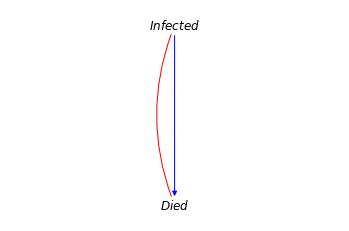

In [1]:
from y0.examples import id_sir_example, nonid_sir_example
from y0.algorithm.identify import Identification, identify, Unidentifiable

nonid_sir_example.graph.draw()


## Causal effect of infection on death with latent confounder (immunocompromised) is not identifiable.

In [10]:
nonid_sir = Identification.from_expression(
    query=P[Infected](Died), 
    estimand=P(Infected, Died), 
    graph=nonid_sir_example.graph
)
try:
    identify(nonid_sir)
except Unidentifiable:
    display(nonid_sir.query.expression)
    display(Latex("is not identifiable given the model"))


P(Died @ -Infected)

<IPython.core.display.Latex object>

## Causal effect of infection on death with hospitalization mediator is identifiable

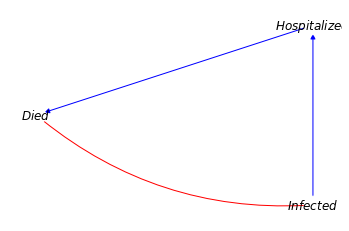

In [11]:
from y0.algorithm.identify import Identification, identify, Unidentifiable
from IPython.display import Latex, Markdown
from y0.dsl import P, Variable, Sum, Product

Infected, Died, Hospitalized = Variable("Infected"), Variable("Died"), Variable("Hospitalized")

id_sir = Identification.from_expression(
    query=P[Infected](Died), 
    estimand=P(Infected, Hospitalized, Died), 
    graph=id_sir_example.graph
)
id_sir.graph.draw()

In [12]:
estimand = identify(id_sir)
display(Latex(f"The query "), id_sir.query.expression, Latex(f"is identifiable and has estimand: "), estimand)

<IPython.core.display.Latex object>

P(Died @ -Infected)

<IPython.core.display.Latex object>

Sum[Hospitalized](P(Hospitalized | Infected) * Sum(Sum[Infected](P(Died | Hospitalized, Infected) * P(Infected))))

$$E[Y_{do(A)} - Y_{do(\lnot A)}]$$

$$\sum_{y_{do(A)}\in dom(Y_{do(A)})}y_{do(A)}P(y_{do(A)}) - \sum_{y_{do(\lnot A)}\in dom(Y_{do(\lnot A)})}y_{do(\lnot A)}P(y_{do(\lnot A)})$$ 